<a href="https://colab.research.google.com/github/Emrhdgr/U-net-segmentation_human_body/blob/main/U-net_segmentation_human_body.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation_models
#!pip install s3fs
#!pip install boto3

unet dilated


In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,"/content/drive/MyDrive/ParcelDelineation/models")
import sys
sys.path.insert(0,"/content/drive/MyDrive/ParcelDelineation/utils")


Mounted at /content/drive


install data (need .json dowload kaggle)

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600  ~/.kaggle/kaggle.json
!kaggle datasets download tapakah68/segmentation-full-body-mads-dataset
!unzip segmentation-full-body-mads-dataset

createcsv


In [3]:
! ls /content/segmentation_full_body_mads_dataset_1192_img/images > /content/images_t.txt
! ls /content/segmentation_full_body_mads_dataset_1192_img/masks > /content/masks_t.txt

In [4]:
import csv
import numpy as np
import pandas as pd

def write_to_csv(pairs, file_name_split_csv, header =['image','mask']):
  with open(file_name_split_csv, 'w') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(header)
    for pair in pairs:
      row0 = pair[0]
      row1 = pair[1]
      rows = [row0, row1]
      csv_writer.writerow(rows)

base = '/content/segmentation_full_body_mads_dataset_1192_img/'
image = 'image/'
mask = 'masks/'

ipath = base + image
mpath = base + mask

df = pd.read_csv('images_t.txt')
df.columns=['path']
df2=pd.read_csv('masks_t.txt')
df2.columns=['path']

ifiles=[]
mfiles=[]

for i in df.path:
  ifiles.append('/content/segmentation_full_body_mads_dataset_1192_img/images/'+ i )

for i in df2.path:
  mfiles.append('/content/segmentation_full_body_mads_dataset_1192_img/masks/'+ i )

mpairs = []

for f in ifiles:
    for f_ in mfiles:
        if f.split('/')[-1] == f_.split('/')[-1]:
            mpairs.append((f, f_))
  
np.random.shuffle(mpairs)
split = len(mpairs)//10*9
citrain = mpairs[:split]
cival = mpairs[split:]

print('Inner train size: {}'.format(len(citrain)))
print('Inner val size: {}'.format(len(cival)))

citrain_csv = '-fdemoscitrain.csv'
cival_csv = '-fdemoscival.csv'

write_to_csv(citrain, citrain_csv)
write_to_csv(cival, cival_csv)


Inner train size: 1071
Inner val size: 120


train


In [ ]:
from keras.preprocessing import image
import segmentation_models as sm
from segmentation_models import Unet
from tensorflow.keras.applications import resnet50, densenet, mobilenet_v2
from keras.models import Model, model_from_json
from keras.layers import Reshape, Concatenate, Conv2D, Conv2DTranspose, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.models import load_model
import keras.losses #import cosine_proximity
from keras import regularizers
from PIL import Image
from random import randint
import unet
import unet_dilated
from data_loader_utils import batch_generator, batch_generator_DG
import metrics 
import numpy as np
import pandas as pd
import glob
import math
import warnings
import keras.backend as K
import keras
import pdb
import tensorflow as tf
import cv2
import sys
from metrics import f1
sm.set_framework('tf.keras')

sm.framework()
assert len(sys.argv)==3
prefix = sys.argv[1]
epoch = 10


Image.MAX_IMAGE_PIXELS = None
warnings.simplefilter('ignore', Image.DecompressionBombWarning)

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

def learning_rate_scheduler(epoch):
    lr = 1e-4
    '''
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 150:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    '''
    print("Set Learning Rate : {}".format(lr))
    return lr


#Set the variables here for training the model 
is_fill = False
is_stacked = False
is_imageNet = True
is_dilated = False # dilated models are only for non-pretrained models 
# image_type = 'sentinel' 

num_channels = 3
if is_stacked:
    num_channels = 9

input_shape = (640, 640, num_channels)
batch_size = 12
base_dir = '/content/'
train_file = prefix + 'demoscitrain.csv'
val_file = prefix +  'demoscival.csv'
filepath = prefix + '-unet-segment.hdf5'
csv_log_file = prefix + '_log_unet_segment.csv'



#Loads training and validation data frame
#Dataframe contains the paths of the images
train_df = pd.read_csv(base_dir + train_file)
val_df = pd.read_csv(base_dir + val_file)

model = None 

if is_dilated:
    model = unet_dilated(input_size = input_shape)
elif is_imageNet:
    model_unet = Unet(BACKBONE, encoder_weights='imagenet')
    if is_stacked: 
        new_model = keras.models.Sequential()
        new_model.add(Conv2D(3, (1,1), padding='same', activation='relu', input_shape=input_shape))
        new_model.add(model_unet)
        model = new_model
    else:
        model = model_unet
else:
    model = unet(input_size=input_shape)



model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=learning_rate_scheduler(0)),
              metrics=['acc', f1])

checkpoint = ModelCheckpoint(filepath, monitor='f1', verbose=1, save_best_only=True, mode='max')
csv_logger = CSVLogger(csv_log_file, append=True, separator=';')
callbacks_list = [checkpoint, csv_logger]

model.fit_generator(batch_generator_DG(train_df, batch_size, is_imageNet), steps_per_epoch=round((len(train_df))/batch_size),
        epochs=int(epoch), validation_data=batch_generator_DG(val_df, batch_size, is_imageNet), validation_steps=round((len(val_df))/batch_size),callbacks=callbacks_list)


predict


In [8]:
# Run python predict_model.py [model path to use] [dataframe file path] 
import sys
import os
import segmentation_models as sm
from keras.preprocessing import image
from tensorflow.keras.applications import resnet50, densenet, mobilenet_v2
from keras.models import Model, model_from_json
from keras.layers import Reshape, Concatenate, Conv2D, Conv2DTranspose, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.models import load_model
import keras.losses  #import cosine_proximity
from keras import regularizers
from PIL import Image
import unet
import unet_dilated
#from models.unet_dilated import unet_dilated
from segmentation_models import Unet
from random import randint
import numpy as np
import pandas as pd
import glob
import math
import warnings
import keras.backend as K
import pdb
import tensorflow as tf
from keras.models import load_model
import keras.losses
from matplotlib import pyplot as plt
from metrics import get_metrics, f1, dice_coef_sim
from data_loader_utils import batch_generator, batch_generator_DG, read_imgs_keraspp

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

def learning_rate_scheduler(epoch):
    lr = 1e-4
    '''
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 150:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    '''
    print("Set Learning Rate : {}".format(lr))
    return lr

#Set the filepaths here for laoding in the file 
is_fill = False
is_stacked = True
is_imageNet = True
is_dilated = False
image_type = 'sentinel' 


batch_size = 1
num_channels = 3
if is_stacked:
    num_channels = 9
if image_type == 'sentinel':
    input_shape = (640, 640, num_channels)

base_dir = '/content/'
val_file = '-fdemoscival' 
filepath= '/content/drive/MyDrive/ParcelDelineation/-f-unet-segment' 
csv_log_file = 'drive/MyDrive/-f_log_unet_segment'

sub_fill = ''
if is_fill:
    sub_fill = '_fill'
#print(val_file)
print(sys.argv[2])
print(len(sys.argv))
#Modify file path depending on fill/boundary task
val_file = val_file + sub_fill + '.csv'
# File path for the model
filepath = filepath + sub_fill + '.hdf5'
# Csv log file
csv_log_file = csv_log_file + sub_fill + '.csv'

#Loads validation data frame
test_df = pd.read_csv(base_dir + val_file)
# pred_dir = "predictions/"

# if not os.path.exists(pred_dir):
#     os.makedirs(pred_dir)
# pred_fname = pred_dir + "unet_predictions.npy"

# model = None 

# if is_dilated:
#     model = unet_dilated(input_size = input_shape)
# elif is_imageNet:
#     model_unet = Unet(BACKBONE, encoder_weights='imagenet')
#     if is_stacked: 
#         new_model = keras.models.Sequential()
#         new_model.add(Conv2D(3, (1,1), padding='same', activation='relu', input_shape=input_shape))
#         new_model.add(model_unet)
#         model = new_model
#     else:
#         model = model_unet
# else:
#     model = unet(input_size=input_shape)

# model.compile(loss='binary_crossentropy',
#               optimizer=Adam(lr=learning_rate_scheduler(0)),
#               metrics=['acc', f1])

# Model file path
#filepath= 'drive/MyDrive/-f_log_unet_segment.csv'
pred_file= "ci_predictions.npy" 
dependencies = {'f1':f1}

model = load_model(filepath, custom_objects=dependencies)

history = model.predict_generator(batch_generator_DG(test_df, batch_size, is_imageNet), steps = round(len(test_df)/batch_size))
history = history.squeeze()
np.save(pred_file, history)

predictions = np.load(pred_file) 
x_true, y_true = read_imgs_keraspp(test_df)
y_true = y_true.flatten()
y_pred = predictions.flatten()

get_metrics(y_true, y_pred, binarized=False)

# print(predictions.shape)
# print(predictions[0].shape)

# for i in range(0, 10):
#   prediction = predictions[i]
#   prediction[prediction > 0.5] = 255
#   prediction[prediction != 255] = 0
#   plt.imsave(pred_dir + str(test_df['image'][i].split('.png')[0]) + '_pred.png')



/root/.local/share/jupyter/runtime/kernel-831eb7d8-6159-4206-aba0-1f4b852e2df7.json
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Dice/ F1 score: 0.8918401546959657
Accuracy score: 0.9918429361979166
Precision recall fscore (0.8077239759017893, 0.995512594667028, 0.8918401546959657, None)


(0.8918401546959657, 0.9918429361979166)

In [9]:
import numpy as np

[[0.21881208 0.06223226 0.065974   ... 0.08341601 0.11778286 0.18808964]
 [0.15724203 0.01507336 0.02098885 ... 0.02494022 0.03553873 0.09708786]
 [0.15285388 0.01111898 0.01424134 ... 0.01767156 0.02552721 0.05841079]
 ...
 [0.09320685 0.01562831 0.01790008 ... 0.01578441 0.01323467 0.06477815]
 [0.1522507  0.03451106 0.02297002 ... 0.0182223  0.01641908 0.06191385]
 [0.41305697 0.14341155 0.10851854 ... 0.07583663 0.07928154 0.10728922]]


<function matplotlib.pyplot.show>

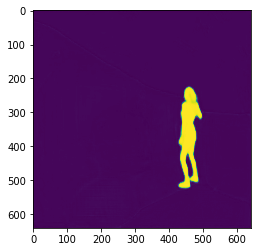

In [11]:
from PIL import Image
import cv2
images = np.load('ci_predictions.npy')
print(images[8])
#print(len(test))
#print(test.shape)
import matplotlib.pyplot as plt
plt.imshow(images[1], interpolation='nearest')
plt.show 

In [ ]:
type(images)

numpy.ndarray

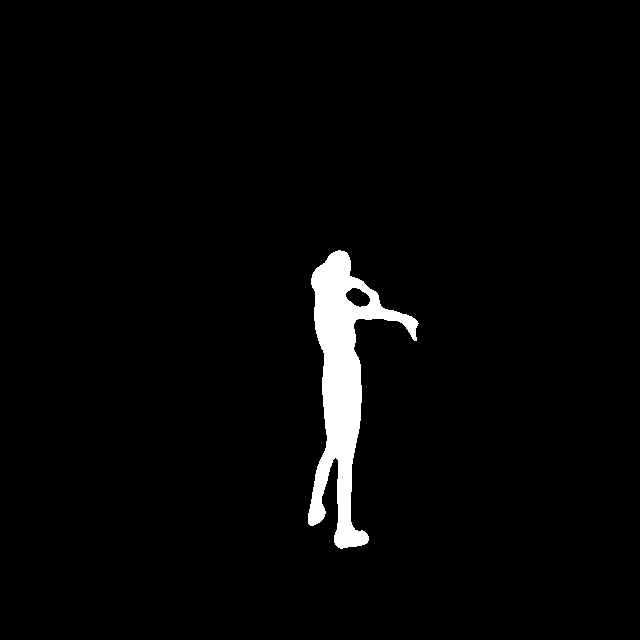

In [13]:
from PIL import Image
import cv2
image = np.load('ci_predictions.npy')
from google.colab.patches import cv2_imshow
amg =[]
for i in range(len(image)):
  img  = image[i]
  img[img < 0.5] = 0
  img[img!=0] = 255
  amg.append(img)

cv2_imshow(amg[5])

In [ ]:
import numpy as np
from PIL import Image
import pandas as pd
import cv2
from tqdm.notebook import tqdm


In [ ]:
image = cv2.imread('orj.png', cv2.IMREAD_UNCHANGED)
mask = cv2.imread('indir.png', cv2.IMREAD_UNCHANGED)

In [ ]:
mask = cv2.resize(mask, image.shape[1::-1])

In [ ]:
mask.shape



(384, 512)

In [ ]:
image.shape

(384, 512, 3)

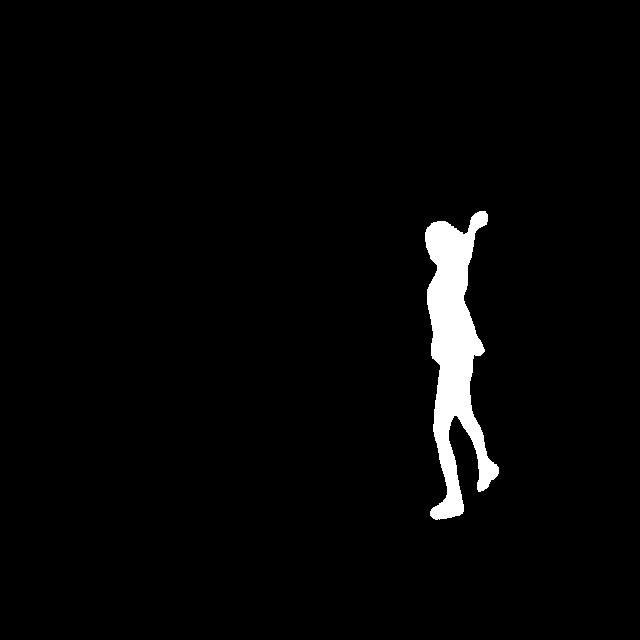

In [ ]:
display(Image.fromarray(mask))

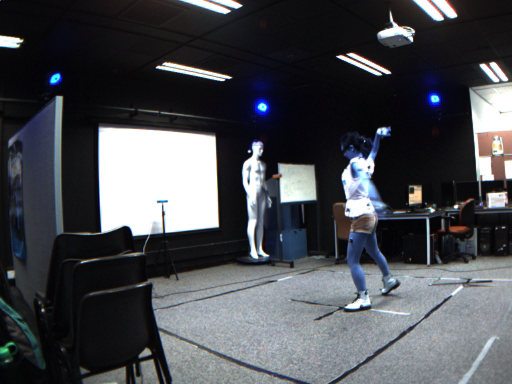

In [ ]:
display(Image.fromarray(image))

Görüntü croplama


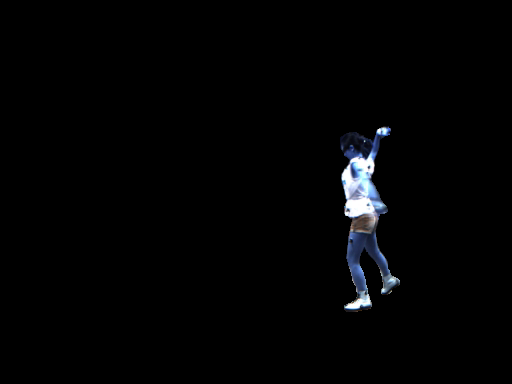

In [ ]:
image_cropped = image.copy()
image_cropped[mask==0] = 0
display(Image.fromarray(image_cropped))

product


# Yeni Bölüm

In [ ]:
def get_predict(img):
  test = Image.open(img)
  test = test.resize((640,640)).convert('RGB')
  test = np.expand_dims(test, axis=0)
  test = np.array(test)
  print(len(test))
  print(test.shape)
  load_model('/content/drive/MyDrive/ParcelDelineation/-f-unet-segment.hdf5', custom_objects=dependencies)
  pred = model.predict(test,
                batch_size=None,
                verbose='auto',
                steps=None,
                callbacks=None,
                max_queue_size=10,
                workers=1,
                use_multiprocessing=True)
  return pred

In [ ]:
get_predict('/content/fullbody.png')

1
(1, 640, 640, 3)


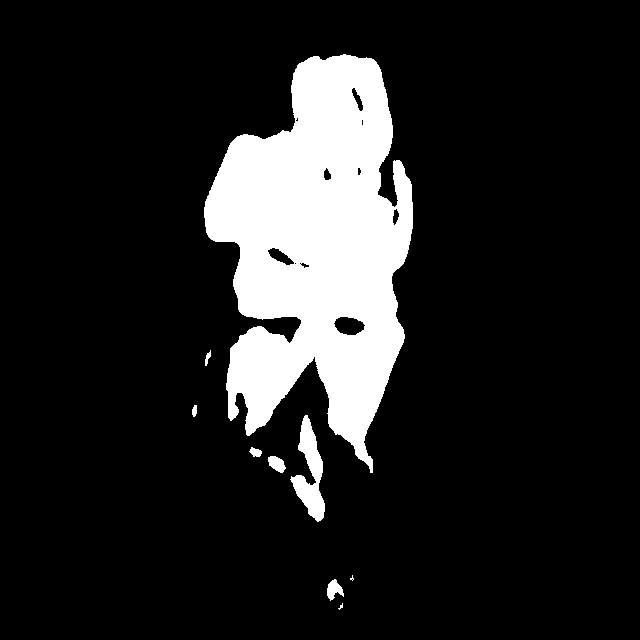

In [ ]:
pred1=get_predict('/content/fullbody.png')
pred1=pred1.reshape(640,640,)
pred1[pred1 < 0.5] = 0
pred1[pred1!=0] = 255


cv2_imshow(pred1)